# Solutions: Lossless Compression With a Variational Autoencoder and Bits-Back Coding

- This notebook is part of the solutions to Problem Set 9, published on 21 June 2023 and discussed on 28 June 2023.
- You can download the full solutions (and the original problem set) from the [course website](https://robamler.github.io/teaching/compress23/).

In this problem, you will use our implementation of a toy variational autoencoder (VAE) losslessly compress images using bits-back coding.

## Lecture + Problem 9.1: Variational Autoencoder (VAE)

We implemented this part in the lecture.
Execute all cells in this part to install dependencies and train the VAE.
While the VAE is training, read the implementation and make sure you understand it (focus on conceptually important part, don't get side tracked by boilerplate code or technical details like the reshaping of tensors).
Then move on to Part 2 below.

### System Setup

Let's install and import some libraries, and set some global configurations.

In [1]:
%pip install torch torchvision matplotlib tqdm


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import time
import sys

In [3]:
USE_CUDA = False # change to True if you have a compatible GPU
RANDOM_SEED = 20230618
BATCH_SIZE = 100
EPOCHS = 10

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if USE_CUDA else "cpu")

### Data Set: Binarized MNIST

We implement a VAE for hand-written digits from the standard MNIST data set.
In this notebook, we use a *binarized* variant of MNIST, i.e., we round the original grayscale pixel values to binary black or white.
This makes the lossless compression task more well-defined because each pixel can only be decoded either completely correctly or completely incorrectly.
It also makes it easier to define some trivial baselines (see below).

In [4]:
def binarize(x):
    return (x >= 0.5).to(x.dtype)

data_transformer = transforms.Compose([
    transforms.ToTensor(),
    binarize
])

train_set = datasets.MNIST('data', train=True, download=True, transform=data_transformer)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_set = datasets.MNIST('data', train=False, download=True, transform=data_transformer)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

#### Visualize Some Training Data Points

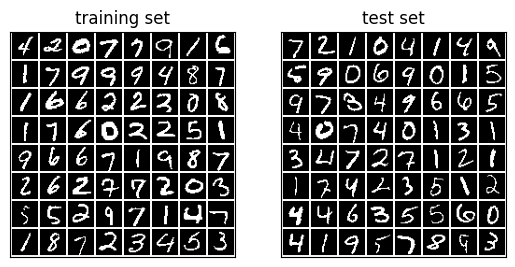

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

def plot_samples(ax, loader, title):
    dat, _ = next(loader.__iter__())
    ax.set_title(title)
    ax.imshow(1 - make_grid(1 - dat.data[:64].float(), padding=2).permute((1, 2, 0)))
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plot_samples(ax1, train_loader, "training set")
plot_samples(ax2, test_loader, "test set")


### Problem 9.1 (a): Trivial Baselines

I strongly recommend to always start with some trivial yet meaningful baselines before digging into more complex methods.
This will give you some rough intuition for how much information is contained in each training data point, so that you can quickly judge the plausibility of results down the road:
- if the compression method that you will implement below turns out to have a higher bit rate than a trivial baseline, then the method is useless;
- if the compression method that you will implement below turns out to have a bit rate that is *orders of magnitude* smaller than what we obtain for some trivial baselines, then the results are suspicious, and you should double-check if you're really measuring the bit rate correctly.

Our trivial baselines consist of two fully factorized models $P({\mathbf X\!=\!\mathbf x}) = \prod_{i,j} P({X_{i,j}\!=x_{i,j}})$, where $(i,j)$ denotes a position in the $28\times28$ grid, and $X_{i,j} \in \{0,1\}$ denotes the pixel value at that position.
The two models are:

1. an i.i.d. model that uses the same distribution $P(X_{i,j})$ for all positions $(i,j)$; and
2. a slightly more general (but still fully factorized) model where the marginal distribution $P(X_{i,j})$ depends on the position $(i,j)$.

We fit both models to the training set and then evaluate the information content of both the training and the test set under each model.
We report the result in "bits per pixel" (BPP) so that we can easily compare to the even more trivial baseline of 1 "raw" bit per pixel.

In [6]:
# Empirical frequencies of the training set:
# (we add 1 white and 1 black pixel at each position $i$ as a regularizer;
# otherwise, the model overfits, and the cross entropy would be infinite).
train_pixel_frequencies = torch.ones((1, 1, 28, 28))
num_train_images = 0
for batch, _ in tqdm(train_loader, file=sys.stdout):
    train_pixel_frequencies += batch.sum(axis=0, keepdim=True)
    num_train_images += len(batch)
train_pixel_frequencies /= num_train_images + 2
train_marginal_frequency = train_pixel_frequencies.mean()

# Information content of the training set (= entropy):
entropy_fully_factorized = (
    -train_pixel_frequencies * torch.log2(train_pixel_frequencies)
    - (1 - train_pixel_frequencies) * torch.log2(1 - train_pixel_frequencies)
    ).mean()
entropy_iid = (
    -train_marginal_frequency * np.log2(train_marginal_frequency)
    - (1 - train_marginal_frequency) * np.log2(1 - train_marginal_frequency))

print("Entropy of training set assuming pixels are i.i.d:         " +
    f"{entropy_iid:.4f} bits per pixel (frequency = {train_marginal_frequency:.4f})")
print("Entropy of training set assuming fully factorized model:   " +
    f"{entropy_fully_factorized:.4f} bits per pixel")
sys.stdout.flush()

# Empirical frequencies of the test set:
test_pixel_frequencies = torch.zeros((1, 1, 28, 28))
num_test_images = 0
for batch, _ in tqdm(test_loader, file=sys.stdout):
    test_pixel_frequencies += batch.sum(axis=0, keepdim=True)
    num_test_images += len(batch)
test_pixel_frequencies /= num_test_images
test_marginal_frequency = test_pixel_frequencies.mean()

# Information content of the test set (= cross entropy):
cross_entropy_fully_factorized = (
    -test_pixel_frequencies * torch.log2(train_pixel_frequencies)
    - (1 - test_pixel_frequencies) * torch.log2(1 - train_pixel_frequencies)
    ).mean()
test_marginal_frequency = test_pixel_frequencies.mean()
cross_entropy_iid = (
    -test_marginal_frequency * np.log2(train_marginal_frequency)
    - (1 - test_marginal_frequency) * np.log2(1 - train_marginal_frequency))

print("Cross entropy of test set assuming pixels are i.i.d:       " +
    f"{cross_entropy_iid:.4f} bits per pixel (frequency = {test_marginal_frequency:.4f})")
print("Cross entropy of test set assuming fully factorized model: " +
    f"{cross_entropy_fully_factorized:.4f} bits per pixel")
sys.stdout.flush()

100%|██████████| 600/600 [00:05<00:00, 109.29it/s]
Entropy of training set assuming pixels are i.i.d:         0.5636 bits per pixel (frequency = 0.1323)
Entropy of training set assuming fully factorized model:   0.3793 bits per pixel
100%|██████████| 100/100 [00:00<00:00, 117.38it/s]
Cross entropy of test set assuming pixels are i.i.d:       0.5689 bits per pixel (frequency = 0.1342)
Cross entropy of test set assuming fully factorized model: 0.3788 bits per pixel


### Definition of Model Components

The classes `EntropyBottleneck`, `EncoderModel`, `DecoderModel`, below implement the prior, inference network, and likelihood, respectively.
This VAE for lossless compression uses the following models:

#### Problem 9.1 (b): `EntropyBottleneck` (Prior)

The class `EntropyBottleneck` implements the bit rate term $D_\text{KL}\big({Q(\mathbf Z\,|\,\mathbf X\!=\!\mathbf x)\,\big|\!\big|\, P(\mathbf Z)}\big)$ from a fixed standard normal prior $P(\mathbf Z) = \mathcal N(0, I)$ to the Gaussian mean field variational distribution defined above.

In [7]:
class EntropyBottleneck(nn.Module):
    """The prior $P(Z)$. A standard normal here."""

    def __init__(self):
        super(EntropyBottleneck, self).__init__()
        # We use a fixed prior here, so the entropy bottleneck has
        # no parameters.

    def forward(self, q_mean, q_log_variance):
        """Returns $KL( Q(Z|X=x) || P(Z) )$."""
        q_variance = q_log_variance.exp()
        return 0.5 * torch.sum(q_variance - 1 + q_mean**2 - q_log_variance)

#### Problem 9.1 (c) (i): `EncoderModel` (Variational Distribution)

The `EncoderModel` is a neural network with weights $\phi$ that takes a batch of images $\mathbf x$ as input and outputs the parameters $\boldsymbol\mu_\phi(\boldsymbol x)$ and $\log \boldsymbol\sigma^2_\phi(\boldsymbol x)$ of a Gaussian mean field (i.e., fully factorized) variational distribution $Q_\phi({\mathbf Z\,|\,\mathbf X\!=\!\mathbf x}) = \mathcal N\big(\boldsymbol\mu_\phi(\mathbf x),\text{diag}(\boldsymbol\sigma^2_\phi(\mathbf x))\big)$.
Here, the network outputs the log-variances rather than the variances so that we can ensure that the variances are always positive, and so that gradients are on a natural (i.e., relative) scale.

In [8]:
class EncoderModel(nn.Module):
    """A Gaussian variational distribution $Q(Z|X)$."""

    def __init__(self, hidden_channels=4, z_channels=6):
        super(EncoderModel, self).__init__()
        self.z_shape = [z_channels, 4, 4]
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=hidden_channels,
            kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=hidden_channels, out_channels=2*z_channels,
            kernel_size=5, stride=2)
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)

    def forward(self, x):
        """Returns the parameters that define $Q(Z|X=x)$ for given $x$."""
        hidden = torch.relu(self.conv1(x))
        out = self.conv2(hidden)
        q_mean = out[:, :self.z_shape[0], :, :]
        q_log_variance = out[:, self.z_shape[0]:, :, :]
        return q_mean, q_log_variance
    
    def reparameterize(self, q_mean, q_log_variance):
        """Draws $z ~ Q(Z|X=x)$ using the reparameterization trick (see Problem 8.2)."""
        q_std = torch.exp(0.5 * q_log_variance) # Using torch.exp ensures that std > 0.
        eps = torch.randn_like(q_std) # `randn` is standard normal distribution.
        return q_mean + q_std * eps

#### Problem 9.1 (c) (ii): `DecoderModel` (Likelihood)

The `DecoderModel` is a neural network with parameters $\theta$ that takes a batch of latent representations $\mathbf z$ as input and outputs so-called logits $\boldsymbol\xi_\theta(\mathbf z)$.
These logits parameterize the likelihood $P_\theta({\mathbf X\,|\,\mathbf Z\!=\!\mathbf z}) = \prod_{i,j} P({X_{i,j}\,|\,\mathbf Z\!=\!\mathbf z})$, where $X_{i,j}$ is the pixel value at position $(i,j)$, and $P({X_{i,j}\!=\!1\,|\,\mathbf Z\!=\!\mathbf z}) = \sigma(\xi_{\theta,i,j}(\mathbf z))$ with the sigmoid function $\sigma(\alpha) := 1/(1+e^{-\alpha})$ (here, the use of the symbol $\sigma$ follows standard conventions; it has no relation to the standard deviation of the variational distribution).

In [9]:
class DecoderModel(nn.Module):
    """The likelihood $P(X|Z)$."""

    def __init__(self, z_channels=6, hidden_channels=4):
        super(DecoderModel, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(
            in_channels=z_channels, out_channels=hidden_channels,
            kernel_size=5, stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(
            in_channels=hidden_channels, out_channels=1,
            kernel_size=5, stride=2, output_padding=1)
        self.log_sigmoid = nn.LogSigmoid()
        nn.init.xavier_uniform_(self.deconv1.weight)
        nn.init.xavier_uniform_(self.deconv2.weight)

    def forward(self, z):
        """Returns the parameters that define $P(X|Z=z)$ for given $z$."""
        hidden = torch.relu(self.deconv1(z))
        logits = self.deconv2(hidden)
        return logits

    def log_likelihood(self, logits, x):
        return torch.sum(
            x * self.log_sigmoid(logits)
            + (1 - x) * self.log_sigmoid(-logits))
    
    def pixel_probabilities(self, logits):
        return torch.sigmoid(logits)

### Problem 9.1 (d): Tying the Components Together

In [10]:
def bit_rates_and_logits(encoder_model, decoder_model, entropy_bottleneck, x):
    """Executes a round trip x --> z --> logits;
    returns bit rates (to base 2) for z and x, respectively, and logits."""
    q_mean, q_log_variance = encoder_model(x)
    z = encoder_model.reparameterize(q_mean, q_log_variance)
    bit_rate_z = entropy_bottleneck(q_mean, q_log_variance) / np.log(2)
    logits = decoder_model(z)
    bit_rate_x_given_z = -decoder_model.log_likelihood(logits, x) / np.log(2)
    return bit_rate_z, bit_rate_x_given_z, logits

### Training and Testing Functions

In [11]:
def train_one_epoch(epoch, train_loader, encoder_model, decoder_model,
                    entropy_bottleneck, optimizer, batches_between_logging=100):
    # Set all parts of the model into training mode.
    encoder_model.train()
    decoder_model.train()
    entropy_bottleneck.train()

    total_bit_rate = 0
    total_num_pixels = 0
    for batch_idx, (batch, _) in enumerate(train_loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        bit_rate_z, bit_rate_x_given_z, _ = bit_rates_and_logits(
            encoder_model, decoder_model, entropy_bottleneck, batch)
        loss = bit_rate_z + bit_rate_x_given_z
        loss.backward()
        optimizer.step()

        total_bit_rate += bit_rate_z + bit_rate_x_given_z
        total_num_pixels += batch.numel()
        
        if batch_idx % batches_between_logging == 0:
            bpp_z = bit_rate_z / batch.numel()
            bpp_x_given_z = bit_rate_x_given_z / batch.numel()
            print(
                f'Training epoch {epoch}, batch {batch_idx: 3d} of {len(train_loader)}: ' +
                f'BPP = {bpp_z:.4f} + {bpp_x_given_z:.4f} = {bpp_z + bpp_x_given_z:.4f}'
            )
            sys.stdout.flush()

    bpp = total_bit_rate / total_num_pixels
    return bpp

In [12]:
def test(test_loader, encoder_model, decoder_model, entropy_bottleneck,):
    # Set all parts of the model into evaluation mode.
    encoder_model.eval()
    decoder_model.eval()
    entropy_bottleneck.eval()

    rendered_reconstructions = None
    total_bit_rate = 0
    total_num_pixels = 0

    with torch.no_grad():
        for i, (batch, _) in enumerate(test_loader):
            batch = batch.to(device)
            bit_rate_z, bit_rate_x_given_z, logits = bit_rates_and_logits(
                encoder_model, decoder_model, entropy_bottleneck, batch)
            total_bit_rate += bit_rate_z + bit_rate_x_given_z
            total_num_pixels += batch.numel()

        # Prepare a tensor that can be plotted to show a few reconstructions.
        reconstructions = decoder_model.pixel_probabilities(logits)
        comparison = torch.cat([batch[:8], reconstructions[:8]])
        rendered_reconstructions = make_grid(comparison.cpu()).permute((1, 2, 0))

        bpp = total_bit_rate / total_num_pixels

    return bpp, rendered_reconstructions

### Train the VAE

In [13]:
encoder_model = EncoderModel().to(device)
decoder_model = DecoderModel().to(device)
entropy_bottleneck = EntropyBottleneck().to(device)

if USE_CUDA > 1:
    encoder_model = nn.DataParallel(encoder_model)
    decoder_model = nn.DataParallel(decoder_model)
    entropy_bottleneck = nn.DataParallel(entropy_bottleneck)

optimizer = optim.Adam(
    list(encoder_model.parameters())
    + list(decoder_model.parameters())
    + list(entropy_bottleneck.parameters()),
    lr=0.01)

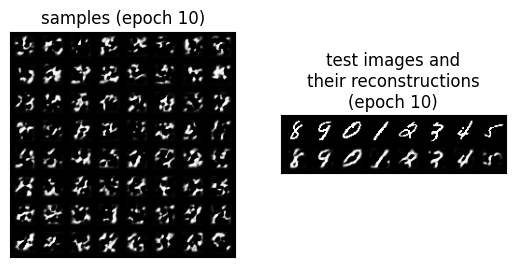

Training epoch 1, batch   0 of 600: BPP = 0.0023 + 1.1081 = 1.1103
Training epoch 1, batch  100 of 600: BPP = 0.0521 + 0.4082 = 0.4604
Training epoch 1, batch  200 of 600: BPP = 0.0626 + 0.3451 = 0.4078
Training epoch 1, batch  300 of 600: BPP = 0.0911 + 0.2362 = 0.3274
Training epoch 1, batch  400 of 600: BPP = 0.0882 + 0.2236 = 0.3118
Training epoch 1, batch  500 of 600: BPP = 0.0953 + 0.1906 = 0.2859
Epoch 1 of 10 (10 sec): train BPP = 0.3939; test BPP = 0.2763

Training epoch 2, batch   0 of 600: BPP = 0.1011 + 0.1735 = 0.2746
Training epoch 2, batch  100 of 600: BPP = 0.0945 + 0.1639 = 0.2584
Training epoch 2, batch  200 of 600: BPP = 0.0955 + 0.1614 = 0.2569
Training epoch 2, batch  300 of 600: BPP = 0.0933 + 0.1575 = 0.2508
Training epoch 2, batch  400 of 600: BPP = 0.1042 + 0.1545 = 0.2588
Training epoch 2, batch  500 of 600: BPP = 0.1000 + 0.1480 = 0.2480
Epoch 2 of 10 (10 sec): train BPP = 0.2601; test BPP = 0.2498

Training epoch 3, batch   0 of 600: BPP = 0.1048 + 0.1479 = 

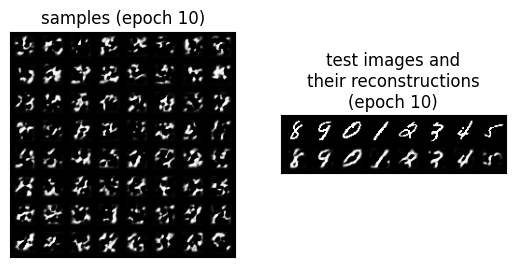

In [14]:
# Create a placeholder figure that will be updated after each epoch below.
figure, (samples_plot, reconstructions_plot) = plt.subplots(1, 2)
samples_plot.set_title('samples')
samples_plot.xaxis.set_visible(False)
samples_plot.yaxis.set_visible(False)
reconstructions_plot.set_title('test images and\ntheir reconstructions')
reconstructions_plot.xaxis.set_visible(False)
reconstructions_plot.yaxis.set_visible(False)
hdisplay = display.display(figure, display_id=True)

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    train_bpp = train_one_epoch(
        epoch, train_loader, encoder_model, decoder_model, entropy_bottleneck,
        optimizer)
    test_bpp, rendered_reconstructions = test(
        test_loader, encoder_model, decoder_model, entropy_bottleneck)
    end_time = time.time()
    print(
        f'Epoch {epoch} of {EPOCHS} ({end_time - start_time:.0f} sec): ' +
        f'train BPP = {train_bpp:.4f}; test BPP = {test_bpp:.4f}\n')
    sys.stdout.flush()

    # Plot some random samples $x ~ P(X)$ and reconstructions of training data.
    samples_plot.set_title(f'samples (epoch {epoch})')
    reconstructions_plot.set_title(
        f'test images and\ntheir reconstructions\n(epoch {epoch})')
    with torch.no_grad():
        samples_z = torch.randn([64] + encoder_model.z_shape).to(device)
        samples_x = decoder_model.pixel_probabilities(decoder_model(samples_z)).cpu()
        samples_plot.imshow(make_grid(samples_x).permute((1, 2, 0)))
    reconstructions_plot.imshow(rendered_reconstructions)
    hdisplay.update(figure)

## Part 2 (Problem 9.2): Lossless Data Compression With the Bits-Back Trick

In this part, you'll use the VAE that you trained in Part 1 above to perform lossless data compression.
Thus, you'll combine the probabilistic machine-learning model with an entropy coder and implement an actual compression method the takes images as input and outputs a bit string.
Your compression method will use the bits-back trick.
You'll then empirically evaluate the actual bit rate of your compression method and check whether it matches the bit rate estimate reported during training of the VAE.

### System Setup

We'll again use the [`constriction`](https://bamler-lab.github.io/constriction/) library that we already used in Problem 7.3 to do the actual entropy coding.

In [15]:
%pip install constriction~=0.3.1


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import constriction

In [17]:
# Get a batch of test images that we can work with.
test_images, _ = next(test_loader.__iter__())

### Problem 9.2 (e): Quantizing the Latent Space

In [18]:
GRID_SPACING = 0.1
Z_CUTOFF = int(round(3 / GRID_SPACING)) # We'll restrict z-space to [-Z_CUTOFF, ..., Z_CUTOFF]

In [19]:
quantized_gaussian = constriction.stream.model.QuantizedGaussian(-Z_CUTOFF, Z_CUTOFF)
quantized_prior = constriction.stream.model.QuantizedGaussian(-Z_CUTOFF, Z_CUTOFF, 0, 1 / GRID_SPACING)
bernoulli = constriction.stream.model.Bernoulli()

In [20]:
def scale_z(z):
    """Scale a vector of latent representations such that all grid points
    have integer coordinates, and clip to the domain of the grid."""
    return ((1 / GRID_SPACING) * z).clip(-Z_CUTOFF, Z_CUTOFF)

def unscale_z(scaled_z):
    """Inverse of `scale_z` (except that clipping and rounding errors
    cannot be inverted)."""
    return GRID_SPACING * scaled_z

def quantize_scaled_z(scaled_z):
    """Map scaled latent representations to the nearest (integer) grid point."""
    return scaled_z.round().astype(np.int32)

def unquantize_scaled_z(quantized_scaled_z):
    """Convert an (integer) grid point to a (float) scaled latent representation."""
    return quantized_scaled_z.astype(np.float32)

### Problem 9.2 (b) Bits-Back Encoder

In [21]:
def encode_single_image(image, ans_coder, bits_back=True):
    # BITSBACK ENCODER STEP 1: decode z using model Q(Z|X=x)
    q_mean, q_log_var = encoder_model(image[None]) # [None] adds a batch dimension
    q_std = torch.exp(0.5 * q_log_var)
    scaled_q_mean = scale_z(q_mean.detach().cpu().numpy())
    scaled_q_std = scale_z(q_std.detach().cpu().numpy())

    if not bits_back or ans_coder.is_empty():
        # If we can't or don't want to use the bits-back trick, then we
        # set z to the grid point closest to the mean of q
        quantized_scaled_z = quantize_scaled_z(scaled_q_mean)
    else:
        quantized_scaled_z = ans_coder.decode(
            quantized_gaussian, scaled_q_mean.ravel(), scaled_q_std.ravel())
        quantized_scaled_z = quantized_scaled_z.reshape(q_mean.shape)

    scaled_z = unquantize_scaled_z(quantized_scaled_z)
    z = unscale_z(scaled_z)

    # BITSBACK ENCODER STEP 2: encode x using model P(X|Z=z)
    logits = decoder_model(torch.tensor(z))
    prob_x = decoder_model.pixel_probabilities(logits)
    prob_x = prob_x.detach().cpu().numpy()
    int_image = image.detach().cpu().numpy().round().astype(np.int32)
    ans_coder.encode_reverse(int_image.ravel(), bernoulli, prob_x.ravel())

    # BITSBACK ENCODER STEP 3: encode z using model P(Z)
    ans_coder.encode_reverse(quantized_scaled_z.ravel(), quantized_prior)

    return q_mean.shape

### Problem 9.2 (c): Bits-Back Decoder

In [27]:
def decode_single_image(ans_coder, z_shape, bits_back=True):
    num_z_items = np.prod(z_shape)

    # BITSBACK DECODER STEP 1: decode z using model P(Z)
    quantized_scaled_z = ans_coder.decode(quantized_prior, num_z_items)
    quantized_scaled_z = quantized_scaled_z.reshape(z_shape)
    z = unscale_z(unquantize_scaled_z(quantized_scaled_z))
    z = GRID_SPACING * quantized_scaled_z.astype(np.float32).reshape(z_shape)

    # BITSBACK DECODER STEP 2: decode x using model P(X|Z=z)
    logits = decoder_model(torch.tensor(z))
    prob_x = decoder_model.pixel_probabilities(logits)
    prob_x = prob_x.detach().cpu().numpy()
    int_image = ans_coder.decode(bernoulli, prob_x.ravel())
    int_image = int_image.reshape(prob_x.shape)[0]
    image = torch.tensor(int_image.astype(np.float32))

    # BITSBACK DECODER STEP 3: encode z using model Q(Z|X=x)
    if bits_back:
        q_mean, q_log_var = encoder_model(image[None]) # [None] adds a batch dimension
        q_std = torch.exp(0.5 * q_log_var)
        scaled_q_mean = scale_z(q_mean.detach().cpu().numpy())
        scaled_q_std = scale_z(q_std.detach().cpu().numpy())
        ans_coder.encode_reverse(
            quantized_scaled_z.ravel(), quantized_gaussian,
            scaled_q_mean.ravel(), scaled_q_std.ravel())

    return image

### Problem 9.2 (a): Testing the Compression Method

In [28]:
def test_compression(images, bits_back=True):
    """Encodes and decodes all images, verifies correctness, prints
    the overall number of bits per pixel (BPP), and returns a vector
    containing the BPP for each image."""
    encoder = constriction.stream.stack.AnsCoder()

    bpps = np.empty(len(images))
    for i, image in enumerate(reversed(images)):
        num_bits_before = encoder.num_bits()
        z_shape = encode_single_image(image, encoder, bits_back=bits_back)
        num_bits_after = encoder.num_bits()
        bpps[i] = (num_bits_after - num_bits_before) / image.numel()

    print(f"Encoded {len(images)} images with a BPP of {bpps.mean():.6f} ± {bpps.std():.6f}")
    compressed = encoder.get_compressed()

    # Verify that the method `num_bits` didn't lie:
    assert compressed.dtype == np.uint32
    assert compressed.size * 32 == num_bits_after

    decoder = constriction.stream.stack.AnsCoder(compressed)
    print("Decoding all images and comparing to originals ...")
    reconstruction = np.stack([
        decode_single_image(decoder, z_shape, bits_back=bits_back)
        for _ in range(len(images))])
    assert np.all(reconstruction == images.detach().cpu().numpy())
    print("Success: Decoded images match originals.")

    return bpps

In [29]:
bpps_map = test_compression(test_images, bits_back=False)

Encoded 100 images with a BPP of 0.708163 ± 0.040969
Decoding all images and comparing to originals ...
Success: Decoded images match originals.


In [30]:
bpps_bitsback = test_compression(test_images, bits_back=True)

Encoded 100 images with a BPP of 0.230612 ± 0.072413
Decoding all images and comparing to originals ...
Success: Decoded images match originals.


*Note:* compare these bit rates to our trivial baseline (which achieved of 0.38 bits per pixel) and to the information content reported at the end of training (which should be very close to the actual bit rate reported here, otherwise there's something wrong with the way we do entropy coding).

## Part 3 (Problem 9.2 (f)): Generalization to Out of Distribution Data (OOD)

### Load The OOD Data Set

Make sure that you have the file `smallkkanji2.npz` that was included in the `zip` file for this problem, and that it is located at the right path.

In [31]:
import torch.utils.data as data_utils

kanji_data = np.load('kkanji2/smallkkanji2.npz')['data'][:, None, :, :]
kanji_data = binarize(torch.tensor(kanji_data.astype(np.float32) / 255))
mock_kanji_labels = torch.zeros((len(kanji_data,))) # We don't need labels but pytorch is very opinionated.

kanji_set = data_utils.TensorDataset(kanji_data, mock_kanji_labels)
kanji_loader = torch.utils.data.DataLoader(kanji_set, batch_size=BATCH_SIZE, shuffle=False)

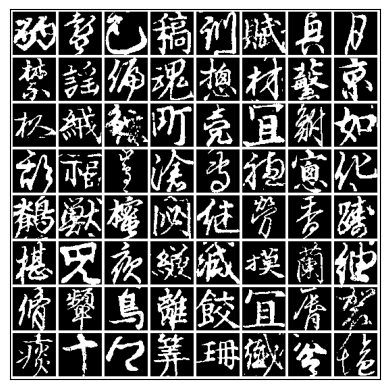

In [32]:
fig, ax = plt.subplots()
ax.imshow(1 - make_grid(1 - kanji_data[:64], padding=4).permute((1, 2, 0)))
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

### Try Encoder and Inspect Latent Dimensions

Even though the VAE was trained on images of a different dimension, it should also work on these images (NB: we are a bit lucky here that the padding works out; in general, deconvolutional layers with a $\mathtt{stride}\neq 1$ can reconstruct images whose dimensions differ slightly from the original, which has to be than resolved by output padding).

In [33]:
train_batch, _ = next(train_loader.__iter__())
q_mean, q_log_var = encoder_model(train_batch)
logits = decoder_model(q_mean)
train_batch.shape, q_mean.shape, logits.shape

(torch.Size([100, 1, 28, 28]),
 torch.Size([100, 6, 4, 4]),
 torch.Size([100, 1, 28, 28]))

In [34]:
kanji_batch, _ = next(kanji_loader.__iter__())
q_mean, q_log_var = encoder_model(kanji_batch)
logits = decoder_model(q_mean)
kanji_batch.shape, q_mean.shape, logits.shape

(torch.Size([100, 1, 64, 64]),
 torch.Size([100, 6, 13, 13]),
 torch.Size([100, 1, 64, 64]))

### Trivial Baselines for OOD Data Set

In [35]:
# Empirical frequencies of the OOD set:
# (we add 1 white and 1 black pixel at each position $i$ as a regularizer;
# otherwise, the model overfits, and the cross entropy would be infinite).
kanji_pixel_frequencies = torch.ones((1, 1, 64, 64))
num_kanji_images = 0
for batch, _ in tqdm(kanji_loader, file=sys.stdout):
    kanji_pixel_frequencies += batch.sum(axis=0, keepdim=True)
    num_kanji_images += len(batch)
kanji_pixel_frequencies /= num_kanji_images + 2
kanji_marginal_frequency = kanji_pixel_frequencies.mean()

# Information content of the OOD set (= entropy):
entropy_fully_factorized = (
    -kanji_pixel_frequencies * torch.log2(kanji_pixel_frequencies)
    - (1 - kanji_pixel_frequencies) * torch.log2(1 - kanji_pixel_frequencies)
    ).mean()
entropy_iid = (
    -kanji_marginal_frequency * np.log2(kanji_marginal_frequency)
    - (1 - kanji_marginal_frequency) * np.log2(1 - kanji_marginal_frequency))

print("Entropy of OOD set assuming pixels are i.i.d:       " +
    f"{entropy_iid:.4f} bits per pixel (frequency = {kanji_marginal_frequency:.4f})")
print("Entropy of OOD set assuming fully factorized model: " +
    f"{entropy_fully_factorized:.4f} bits per pixel")
sys.stdout.flush()


100%|██████████| 10/10 [00:00<00:00, 596.34it/s]
Entropy of OOD set assuming pixels are i.i.d:       0.8052 bits per pixel (frequency = 0.2462)
Entropy of OOD set assuming fully factorized model: 0.7014 bits per pixel


### Test VAE on OOD Data Set

OOD data has BPP = 0.4116


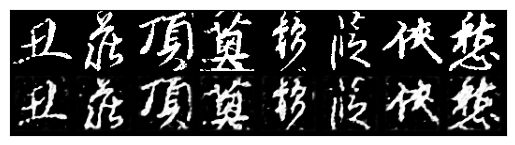

In [36]:
kanji_bpp, kanji_reconstruction_plot = test(kanji_loader, encoder_model, decoder_model, entropy_bottleneck)
print(f'OOD data has BPP = {kanji_bpp:.4f}')
ax = plt.imshow(kanji_reconstruction_plot.detach());
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

### Test Compression Method on OOD Data Set

In [37]:
test_compression(kanji_data, bits_back=False);

Encoded 1000 images with a BPP of 1.423156 ± 0.077728
Decoding all images and comparing to originals ...
Success: Decoded images match originals.


In [38]:
test_compression(kanji_data, bits_back=True);

Encoded 1000 images with a BPP of 0.412484 ± 0.093735
Decoding all images and comparing to originals ...
Success: Decoded images match originals.
